In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

data = pd.read_excel('EPOC dataset.xlsx')

columns = ['metal','support','wt.%','ionic species','particle size(nm)','metal loading (mg)','CO2:H2 ratio','temp(℃)','rCO(mol/s)',
          'voltage(V)','ρCO','ΛCO']
data = data[columns]

# change string in data['metal'] into int with metal's atomic mass
data['metal'] = data['metal'].replace(['Fe','Co','Ni','Cu','ZnO','Ru','Rh','Pd','Pt'],
                                      ['55.8','58.9','58.7','63.5','65.4','101.1','102.9','106.4','195.1']).astype(float)

# change string in data['wt.%'] into int, where 100: no support
data['wt.%'] = data['wt.%'].fillna(100).astype(float)


# change string in data['CO2:H2 ratio'] into int by calculating the ratios
data['gas ratio'] = data['CO2:H2 ratio'].apply(lambda x: int(x.split(':')[0]) / int(x.split(':')[1]))

# delete the data['CO2:H ratio'] column, which has been converted into data['gas ratio']
data = data.drop('CO2:H2 ratio', axis=1)

# change the columns' names into abbreviations, where M:metal, S:support, WT.%:wt.%, IS:ionic species, PS:particle size,
# L:metal loading, T: temperature, RR:reaction rate, V:applied potential, ρ:enhancement ratio, Λ:Faradaic efficiency, GR:gas ratio
data.columns = ['M','S','WT','IS','PS','L','T','RR','V','ρ','Λ','GR']

# determine the ionic species charge
ionic_charge = {
    'O2-': -2,
    'H+': 1,
    'Li+': 1,
    'Na+': 1,
    'K+': 1,
    'none': 0
}
data['IS_charge'] = data['IS'].replace(ionic_charge).fillna(0).astype(float)

# define a function to determine which direction the IS migrates. Value of 1 means IS moves to catalyst, -1 means IS removes from catalyst
def ionic_dir(row):
    if row['IS_charge'] * row['V'] < 0:
        return 1
    else:
        return -1
# create a new column named 'MD' (migration direction)
data['MD'] = data.apply(ionic_dir, axis=1)

# define a function to make a classification for EPOC behavior based on the applied potential and ρ values
# 0: electrophobic, 1: electrophilic
def electro_class(row):
    if row['V'] > 0 and row['ρ'] >= 1:
        return 0
    elif row['V'] < 0 and row['ρ'] >= 1:
        return 1
    elif row['V'] > 0 and row['ρ'] <= 1:
        return 1
    elif row['V'] < 0 and row['ρ'] <= 1:
        return 0
    else:
        return 'undefined'

# create a new column named 'BH' (EPOC behavior)
data['BH'] = data.apply(electro_class, axis=1)


# determine the columns that are used as features in classification
clf_features = ['M', 'L', 'V', 'T', 'GR']

X = data[clf_features].copy()
y = data['BH'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
from sklearn.model_selection import cross_val_score

In [2]:
# GridSearchCV to find out the best parameters for RFC
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators': [5, 10, 15, 20],
    'max_depth': [5, 6, 7, 8],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 4]
}

RFC = RandomForestClassifier(random_state=0)
grid_search = GridSearchCV(estimator=RFC, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 15}
Best Score: 0.9345238095238095


[0.8482142857142858, 0.8278911564625849, 0.8443877551020409, 0.8482142857142858, 0.8318877551020408, 0.852295918367347, 0.8726190476190476, 0.8932823129251701, 0.8931972789115645, 0.89328231292517, 0.8892857142857142, 0.9015306122448979]
[0.8524590163934426, 0.8688524590163934, 0.8852459016393442, 0.8688524590163934, 0.9016393442622951, 0.9016393442622951, 0.8852459016393442, 0.9016393442622951, 0.9016393442622951, 0.819672131147541, 0.8852459016393442, 0.9344262295081968]
[0.9090909090909091, 0.9512195121951219, 0.9523809523809523, 0.8936170212765957, 0.9534883720930233, 0.9534883720930233, 0.9130434782608695, 1.0, 0.975609756097561, 0.9047619047619048, 0.975, 1.0]
[0.8888888888888888, 0.8666666666666667, 0.8888888888888888, 0.9333333333333333, 0.9111111111111111, 0.9111111111111111, 0.9333333333333333, 0.8666666666666667, 0.8888888888888888, 0.8444444444444444, 0.8666666666666667, 0.9111111111111111]
[0.8988764044943819, 0.9069767441860465, 0.9195402298850575, 0.9130434782608695, 0.9

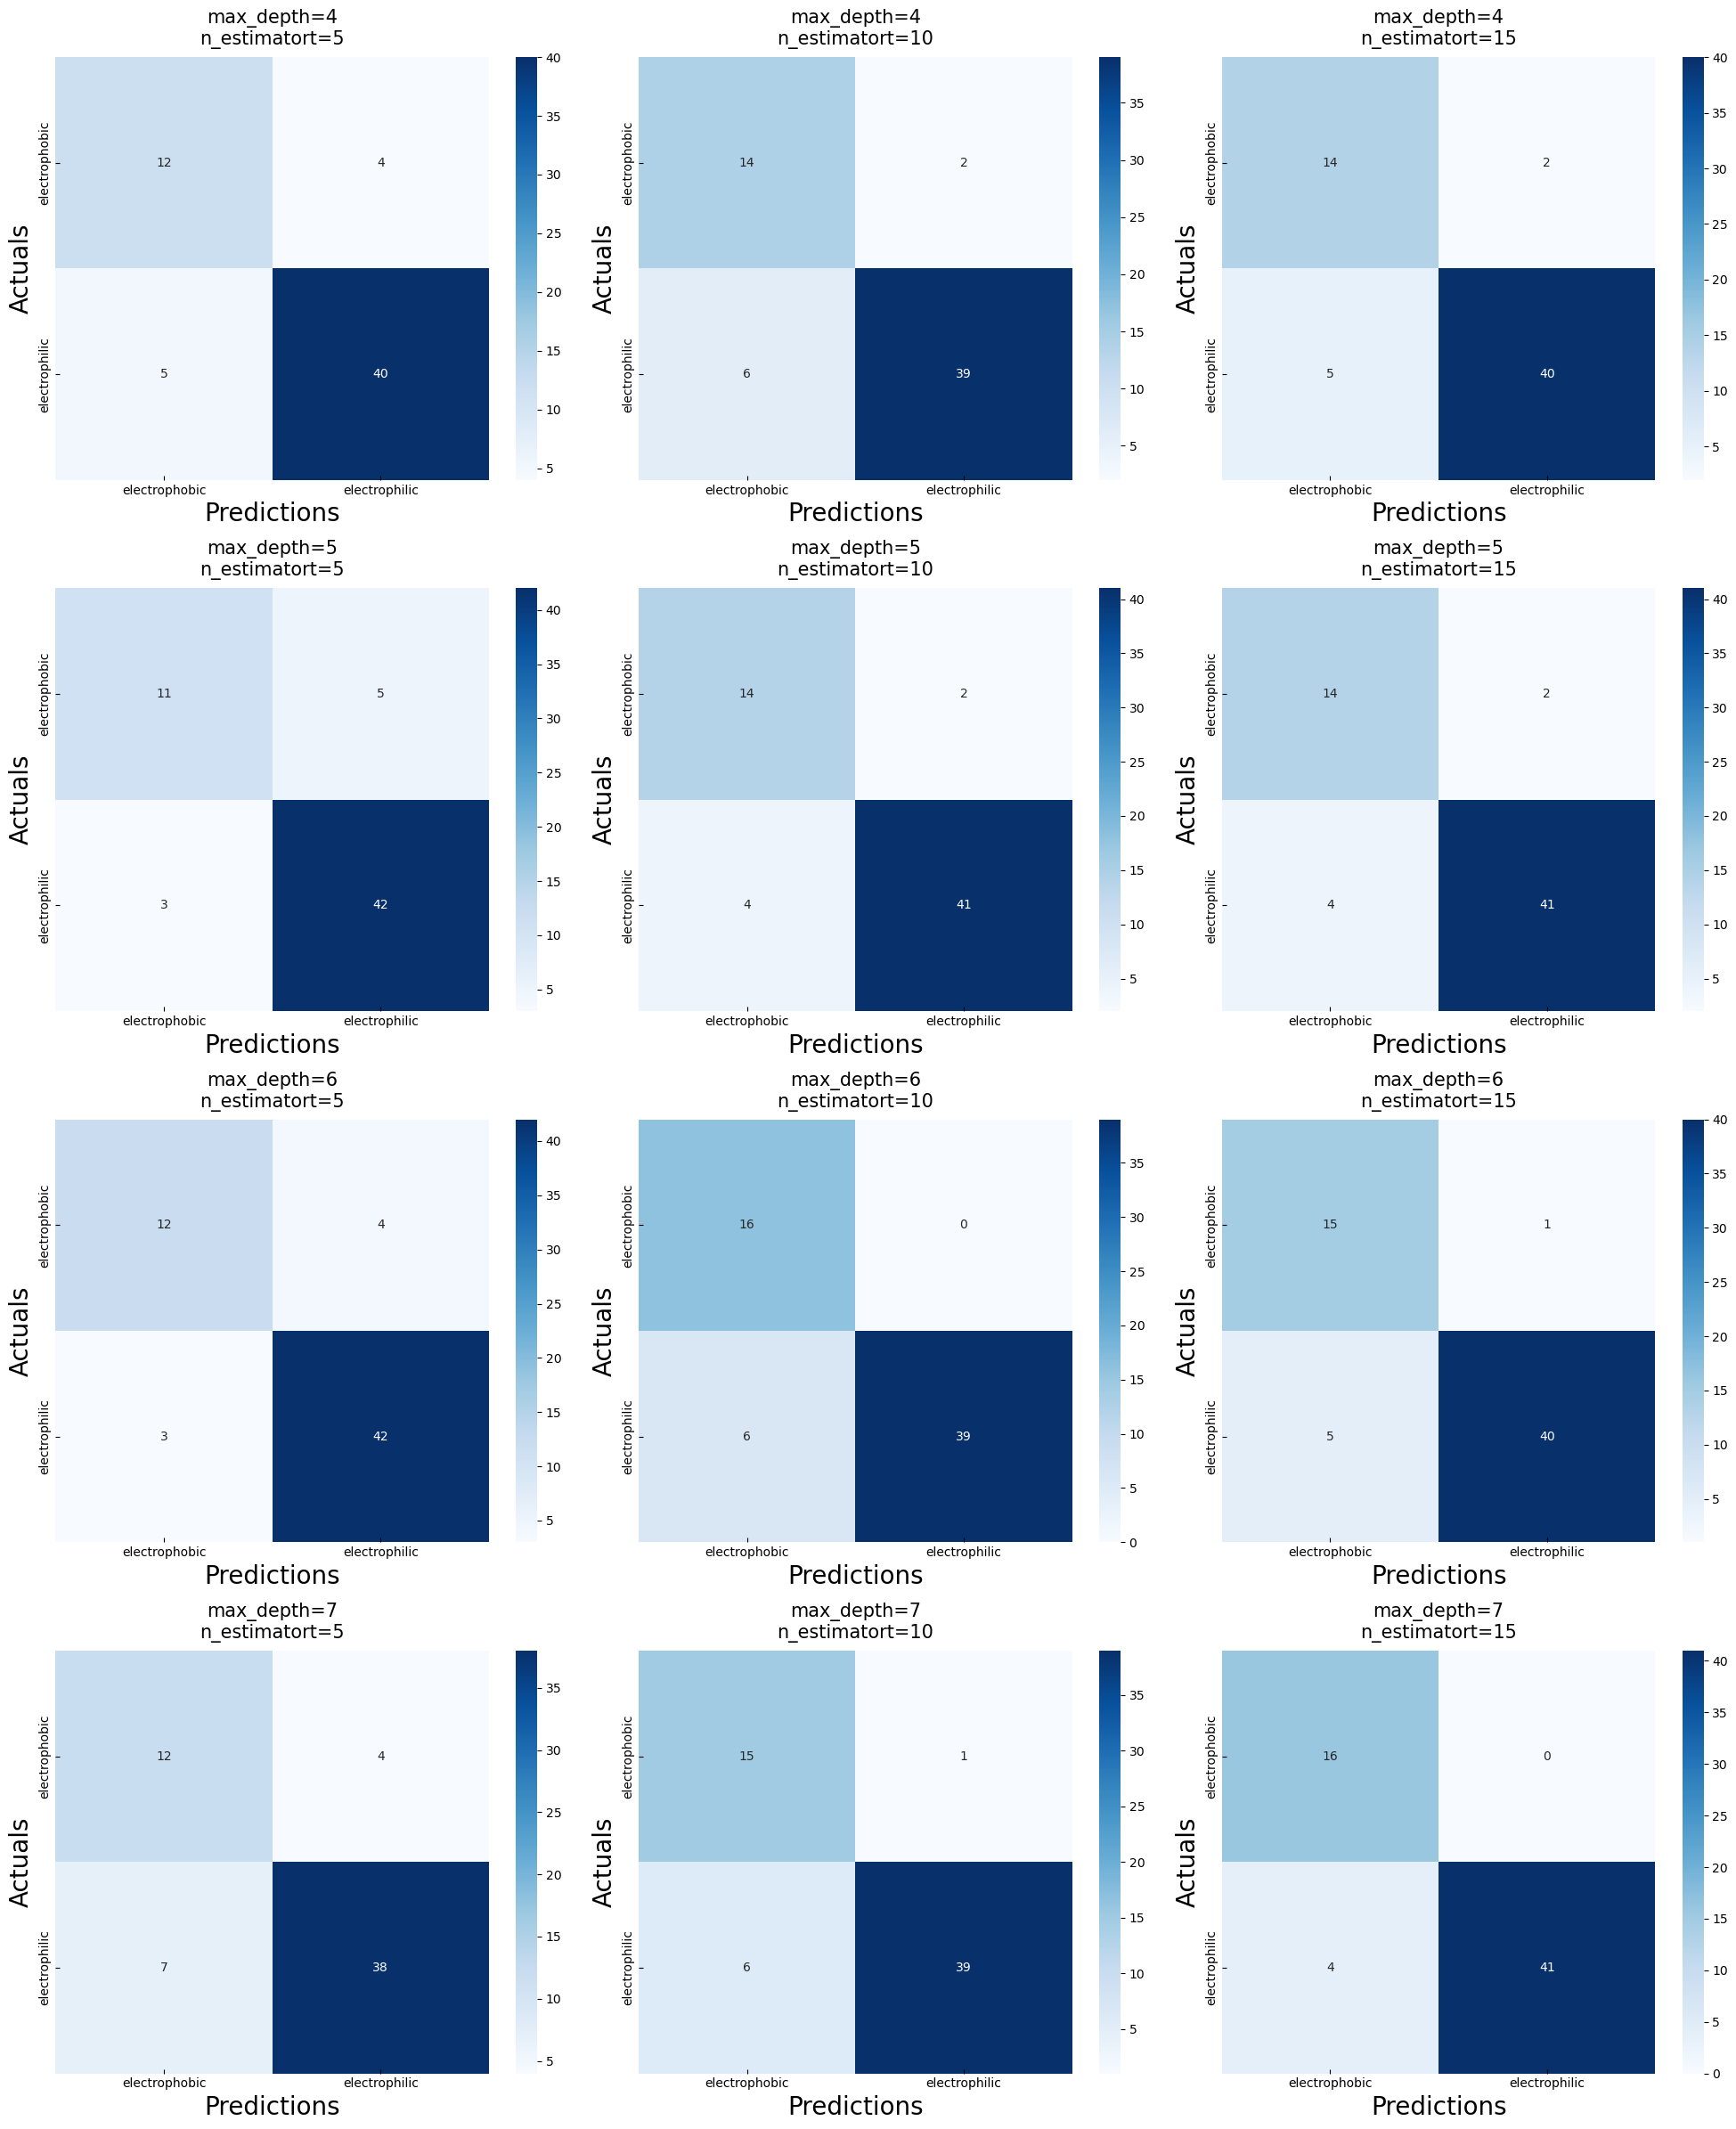

In [31]:
from sklearn.ensemble import RandomForestClassifier
# Random Forest Classifier

m = [4,5,6,7]
n = [5,10,15]

fig, subaxes = plt.subplots(len(m), len(n), figsize=(len(m)*5, len(n)*8))

all_acc = []
all_pre = []
all_rec = []
all_f1 = []
all_cross_val = []

for i, this_m in enumerate(m):
    for j, this_n in enumerate(n):
        RFC = RandomForestClassifier(n_estimators=this_n, max_depth=this_m, min_samples_split=2, random_state=0)
        RFC.fit(X_train, y_train)
        y_predict = RFC.predict(X_test)

        cm = confusion_matrix(y_test, y_predict)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=subaxes[i,j],
                    xticklabels=['electrophobic', 'electrophilic'], yticklabels=['electrophobic', 'electrophilic'])
        subaxes[i,j].set_title(f'max_depth={this_m}\nn_estimatort={this_n}', pad=10, fontsize=15)
        subaxes[i,j].set_xlabel('Predictions', size=20)
        subaxes[i,j].set_xticklabels(subaxes[i,j].get_xticklabels(), fontsize=20)
        subaxes[i,j].set_ylabel('Actuals', size=20)
        subaxes[i,j].set_yticklabels(subaxes[i,j].get_yticklabels(), fontsize=20)
        subaxes[i,j].tick_params(which='both', direction='in', labelsize=10)

        cross_val = cross_val_score(RFC, X_train, y_train, cv=5)
        acc = accuracy_score(y_test, y_predict)
        pre = precision_score(y_test, y_predict)
        rec = recall_score(y_test, y_predict)
        f1 = f1_score(y_test, y_predict)

        all_cross_val.append(cross_val.mean())
        all_acc.append(acc)
        all_pre.append(pre)
        all_rec.append(rec)
        all_f1.append(f1)

print(all_cross_val)
print(all_acc)
print(all_pre)
print(all_rec)
print(all_f1)
plt.tight_layout()
plt.savefig('RFC classification matrix.jpg', format='jpeg', dpi=600)
plt.show()

0.8931972789115645
0.9016393442622951
0.975609756097561
0.8888888888888888
0.9302325581395349


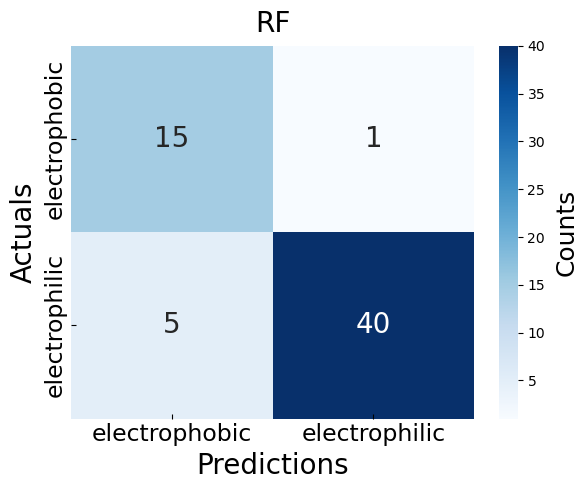

Using 244 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/61 [00:00<?, ?it/s]

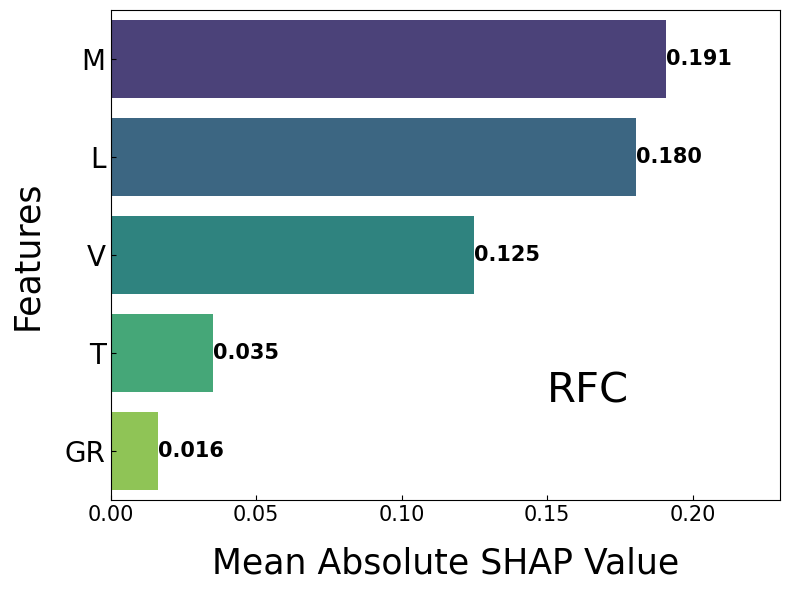

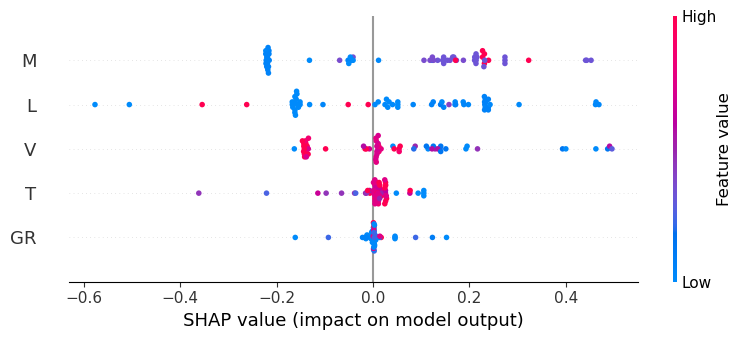

[0 1]


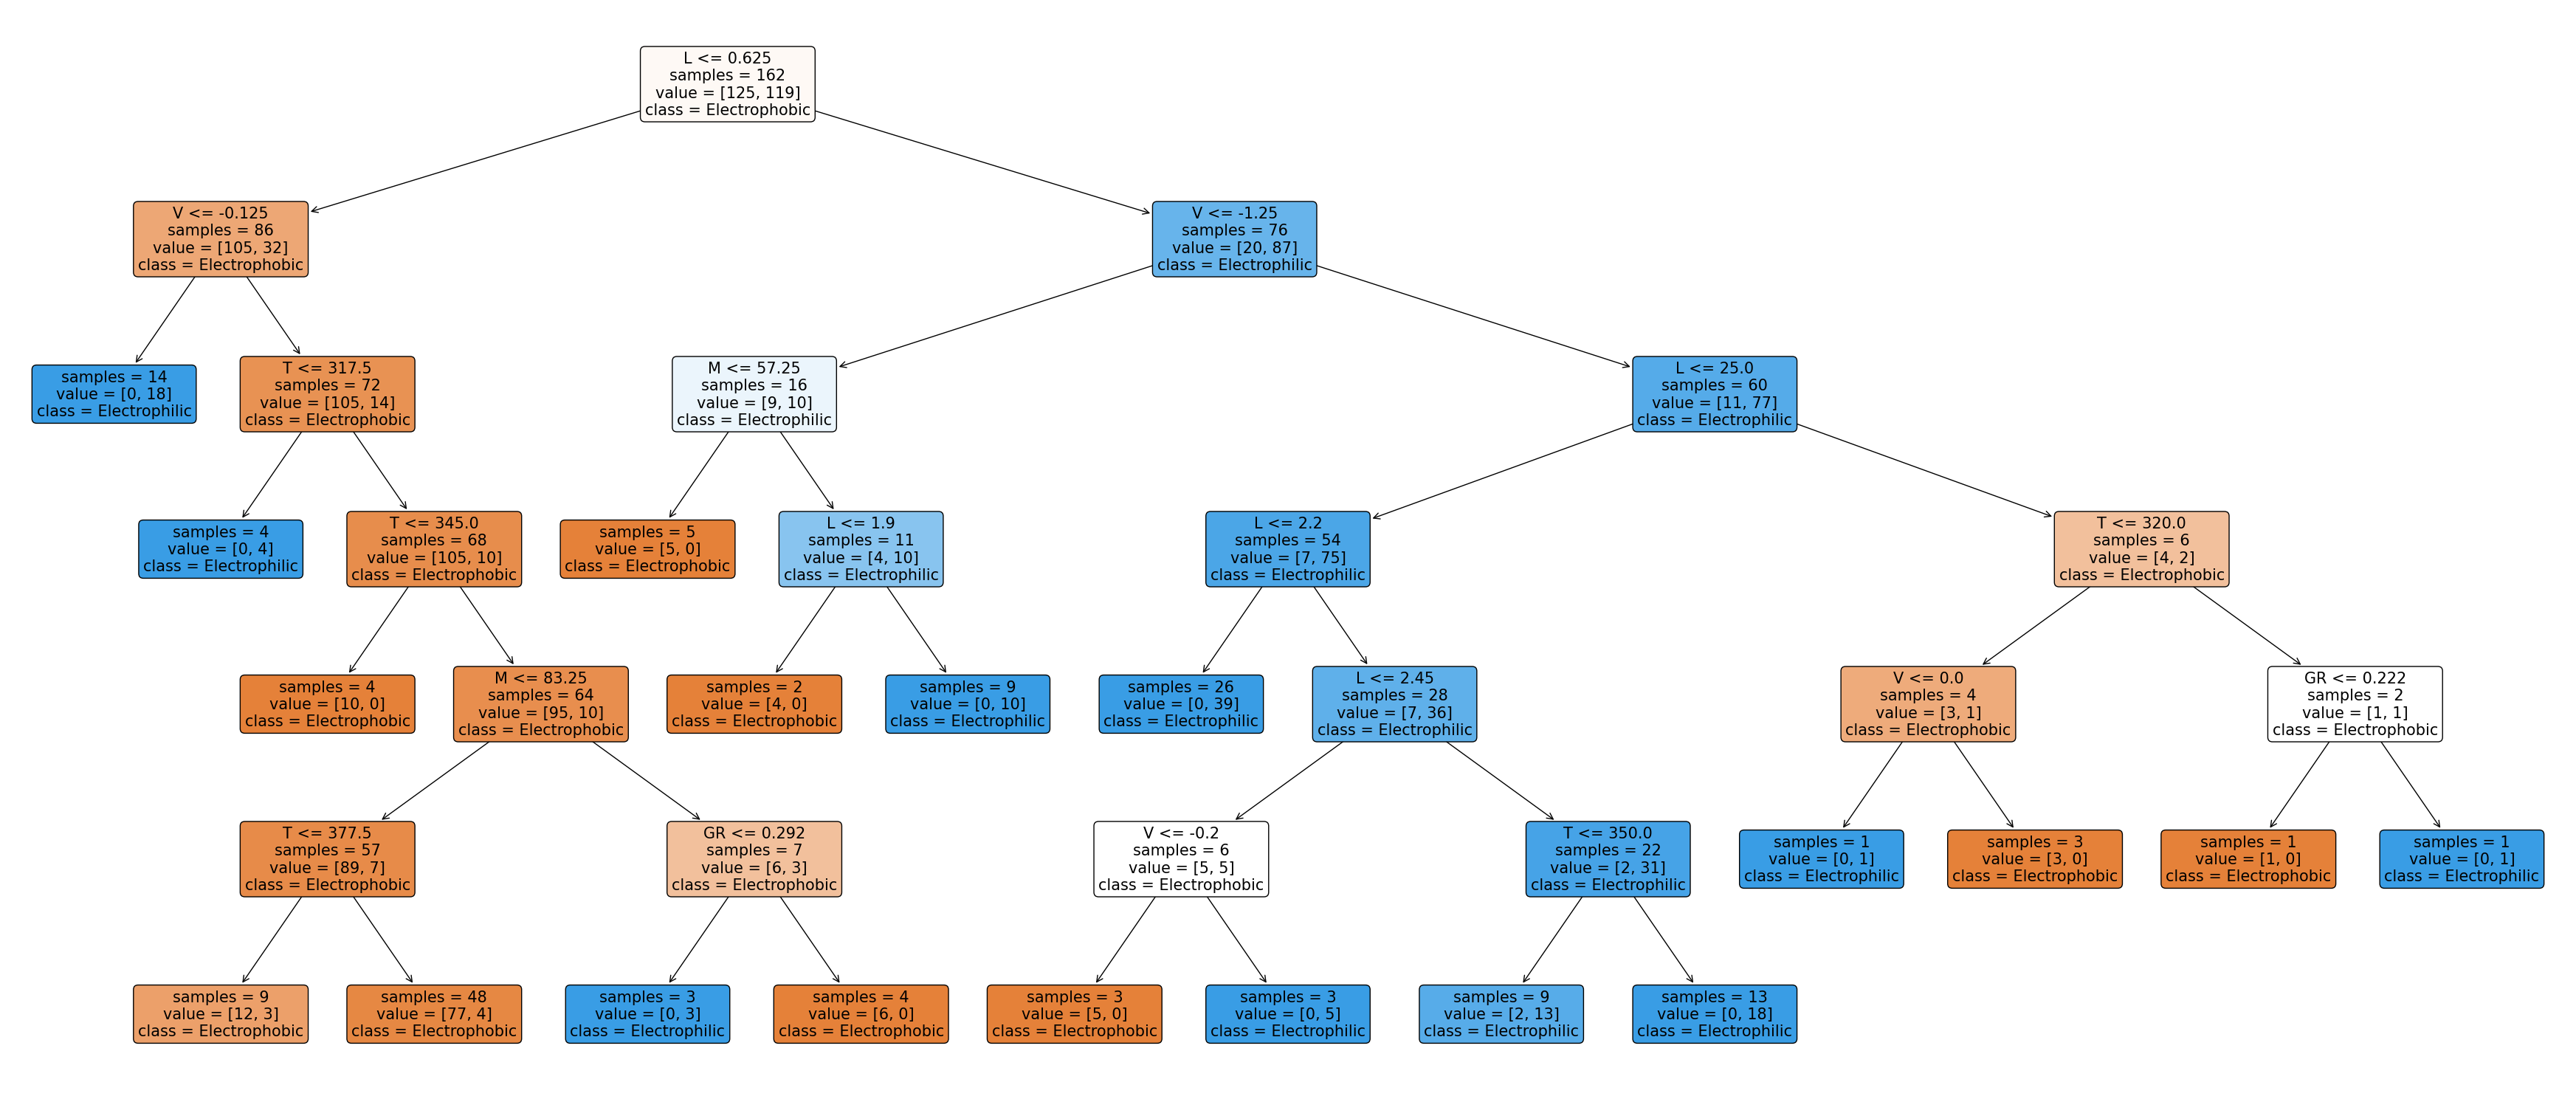

In [42]:
from sklearn.ensemble import RandomForestClassifier
# The Best RFClassifier
RFC_best = RandomForestClassifier(n_estimators=15, max_depth=6, min_samples_split=2, random_state=0)
RFC_best.fit(X_train, y_train)
y_predict = RFC_best.predict(X_test)

cm = confusion_matrix(y_test, y_predict)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['electrophobic', 'electrophilic'], yticklabels=['electrophobic', 'electrophilic'], annot_kws={'size': 20})

cross_val_best = cross_val_score(RFC_best, X_train, y_train, cv=5)
acc = accuracy_score(y_test, y_predict)
pre = precision_score(y_test, y_predict)
rec = recall_score(y_test, y_predict)
f1 = f1_score(y_test, y_predict)

plt.title('RF', pad=10, fontsize=20)
plt.xlabel('Predictions', size=20)
plt.ylabel('Actuals', size=20)
plt.tick_params(which='both', direction='in', labelsize=17)
plt.text(2.4, 1, 'Counts', fontsize=18, va='center', ha='left', rotation=90)

print(cross_val_best.mean())
print(acc)
print(pre)
print(rec)
print(f1)

plt.tight_layout()
plt.savefig('RFC Confusion Matrix.jpg', format='jpeg', dpi=600)
plt.show()


# use SHAP to explain and visualize the feature importance
import shap
shap.initjs()
# Creating the KernelExplainer
RFC_explainer = shap.KernelExplainer(RFC_best.predict, X_train)
RFC_shap_values = RFC_explainer.shap_values(X_test)
# Generating the bar plot with mean SHAP values and feature names
# Calculate mean absolute SHAP values for each feature
mean_abs_shap_values = np.mean(np.abs(RFC_shap_values), axis=0)

# Create a DataFrame for plotting with SHAP values
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': mean_abs_shap_values})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
# Plotting the feature importances with values
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
# Adding the values on the bars
for index, value in enumerate(importance_df['Importance']):
    plt.text(value, index, f'{value:.3f}', va='center', ha='left', color='black', fontweight='bold', fontsize=15)

plt.xlim(0,0.23)
plt.xlabel('Mean Absolute SHAP Value', size=25, labelpad=15)
plt.ylabel('Features', size=25, labelpad=15)
plt.tick_params(axis='x', direction='in', labelsize=15)
plt.tick_params(axis='y', direction='in', labelsize=20)
plt.text(0.15, len(importance_df) - 1.5, 'RFC', fontsize=30)
plt.tight_layout()
plt.savefig('RFC SHAP.jpg', format='jpeg', dpi=600)
plt.show()
# Generating the summary plot showing the distribution of SHAP values for each feature
shap.summary_plot(RFC_shap_values, X_test, feature_names=X.columns)


# plot the tree structure
from sklearn.tree import plot_tree
# check the class labels, where 0 is electrophobic and 1 is electrophilic
class_labels = RFC_best.classes_
print(class_labels)
# [0,1] means the first class in class_names is electrophobic and the second is electrophilic

# select the 3rd tree in RFClassifier as example and show
tree_clf = RFC_best.estimators_[2]
plt.figure(figsize=(35,15))
plot_tree(tree_clf, feature_names=clf_features, filled=True, rounded=True,
          class_names=['Electrophobic', 'Electrophilic'], impurity=False, fontsize=15)
plt.tight_layout()
#plt.savefig('RFC_tree.jpg', format='jpeg', dpi=300)
plt.show()

In [5]:
# GridSearchCV to find out the best parameters for SVC
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [0.001, 0.01, 0.1, 1, 10, 100],
    'kernel': ['rbf', 'sigmoid']
}

SVM_C = SVC(random_state=0)
grid_search = GridSearchCV(estimator=SVM_C, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train, y_train)


print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


Best Parameters: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Best Score: 0.9180272108843537


[0.7170918367346939, 0.7497448979591836, 0.7459183673469387, 0.7990646258503401, 0.8688775510204081, 0.7213435374149659, 0.7418367346938776, 0.893452380952381, 0.9180272108843537, 0.8852891156462585, 0.7172619047619048, 0.8851190476190476, 0.9179421768707483, 0.9096938775510204, 0.9096938775510204, 0.6597789115646259, 0.856547619047619, 0.8729591836734694, 0.8729591836734694, 0.8729591836734694, 0.5409863945578232, 0.750170068027211, 0.750170068027211, 0.750170068027211, 0.750170068027211, 0.536904761904762, 0.6888605442176872, 0.6888605442176872, 0.6888605442176872, 0.6888605442176872]
[0.7377049180327869, 0.7049180327868853, 0.7540983606557377, 0.8524590163934426, 0.8852459016393442, 0.7540983606557377, 0.7540983606557377, 0.8524590163934426, 0.9016393442622951, 0.9016393442622951, 0.7540983606557377, 0.8360655737704918, 0.9016393442622951, 0.8688524590163934, 0.8688524590163934, 0.7704918032786885, 0.8524590163934426, 0.819672131147541, 0.8032786885245902, 0.8032786885245902, 0.7377

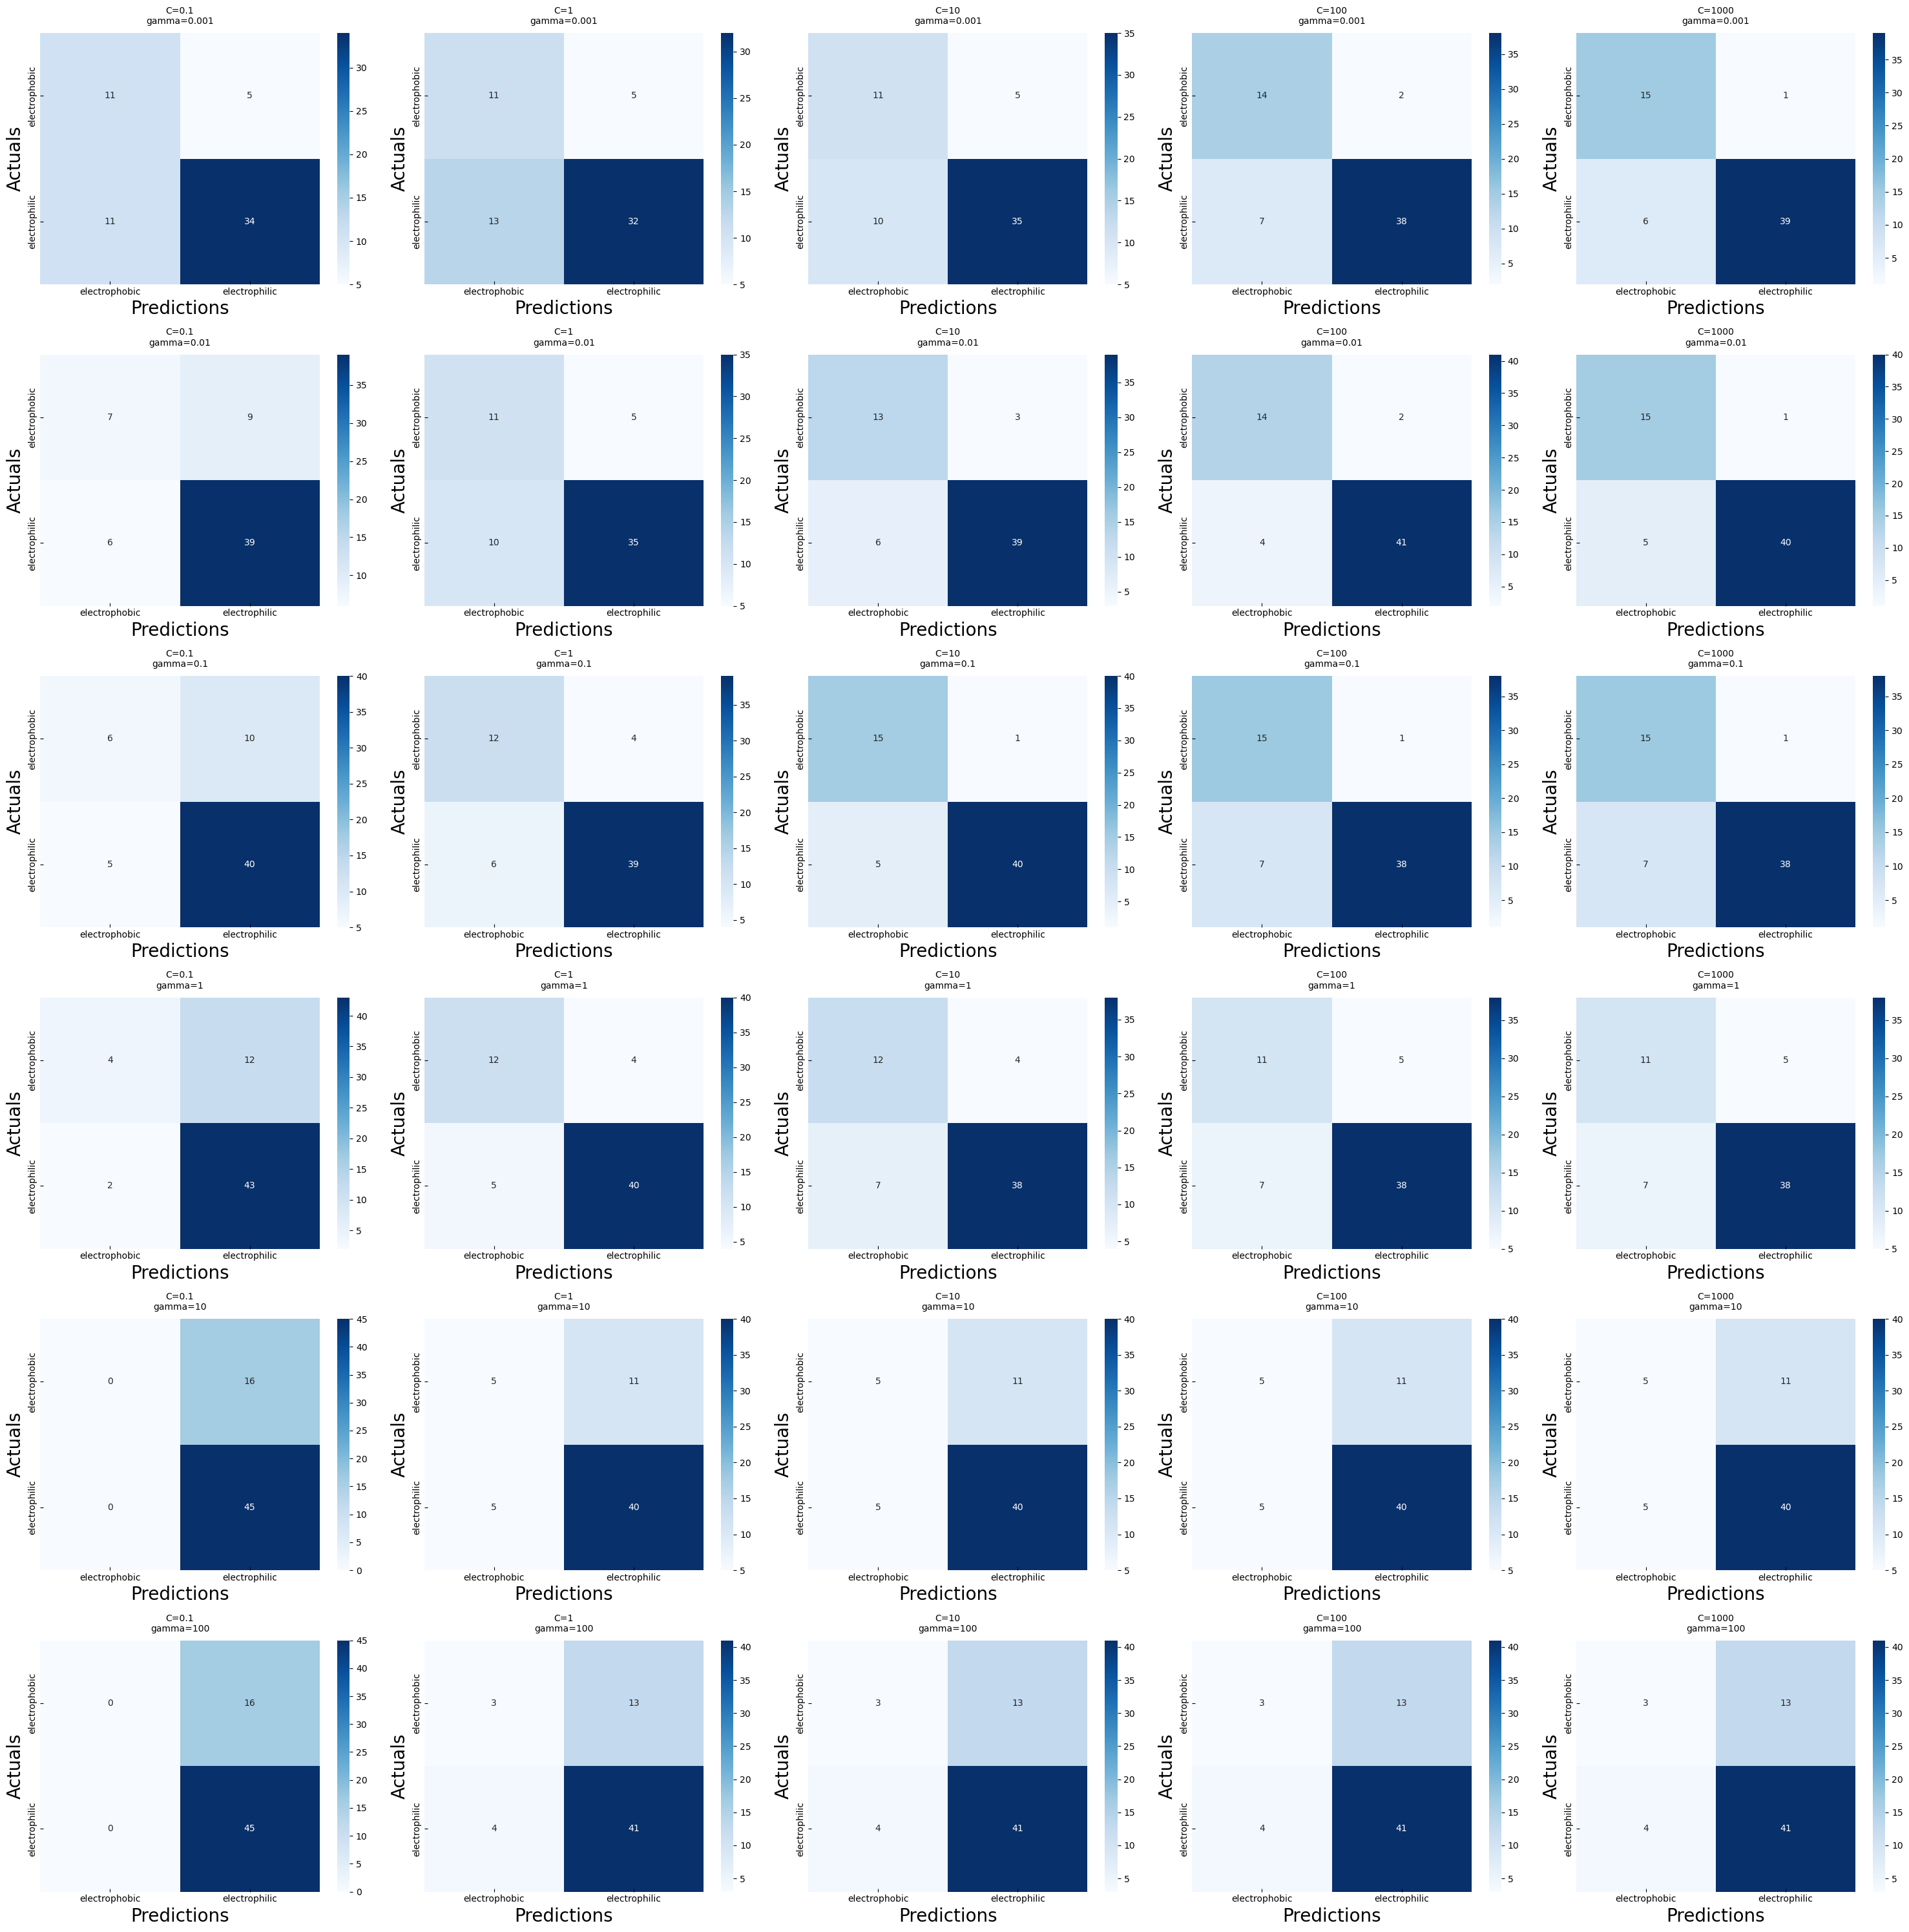

In [6]:
from sklearn.svm import SVC
# Support Vector Machine Classifier

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score


C_range = [0.1, 1, 10, 100, 1000]
gamma_range = [0.001, 0.01, 0.1, 1, 10, 100]

fig, subaxes = plt.subplots(len(gamma_range), len(C_range), figsize=(len(gamma_range)*5, len(C_range)*6))

all_acc = []
all_pre = []
all_rec = []
all_f1 = []
all_cros_val = []

for i, this_gamma in enumerate(gamma_range):
    for j, this_C in enumerate(C_range):
        
        SVM_C = SVC(kernel='rbf', C=this_C, gamma=this_gamma)
        SVM_C.fit(X_train, y_train)
        y_predict = SVM_C.predict(X_test)

        cm = confusion_matrix(y_test, y_predict)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=subaxes[i,j],
                   xticklabels=['electrophobic','electrophilic'], yticklabels=['electrophobic','electrophilic'])
        
        subaxes[i,j].set_title(f'C={this_C}\ngamma={this_gamma}', pad=10, size=10)
        subaxes[i,j].set_xlabel('Predictions', size=20)
        subaxes[i,j].set_ylabel('Actuals', size=20)
        subaxes[i,j].tick_params(direction='in', which='both')

        cros_val = cross_val_score(SVM_C, X_train, y_train, cv=5)
        acc = accuracy_score(y_test, y_predict)
        pre = precision_score(y_test, y_predict)
        rec = recall_score(y_test, y_predict)
        f1 = f1_score(y_test, y_predict)

        all_cros_val.append(cros_val.mean())
        all_acc.append(acc)
        all_pre.append(pre)
        all_rec.append(rec)
        all_f1.append(f1)

print(all_cros_val)
print(all_acc)
print(all_pre)
print(all_rec)
print(all_f1)
plt.subplots_adjust(wspace=0.3, hspace=0.3)

plt.tight_layout()
plt.savefig('SVC classification matrix.jpg', format='jpeg', dpi=600)
plt.show()

0.9179421768707483
0.9016393442622951
0.975609756097561
0.8888888888888888
0.9302325581395349


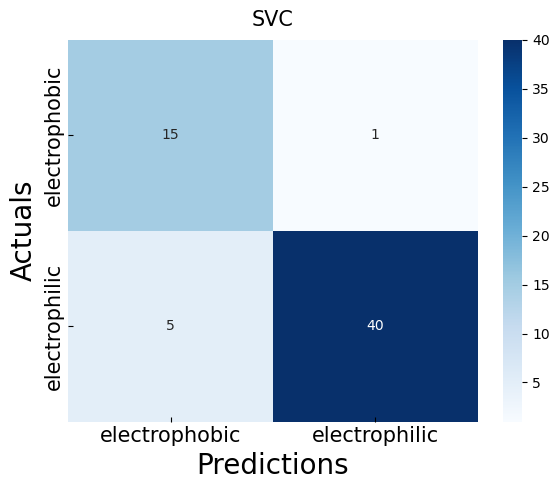

Using 244 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/61 [00:00<?, ?it/s]

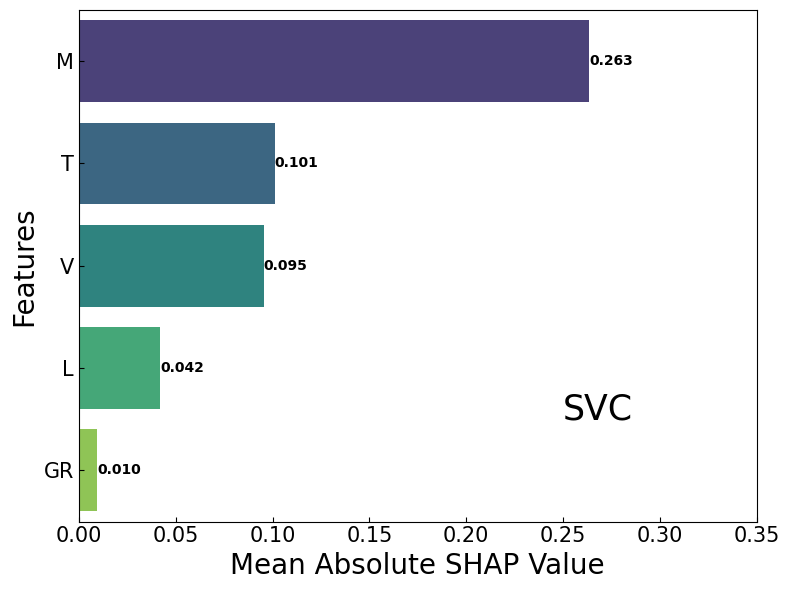

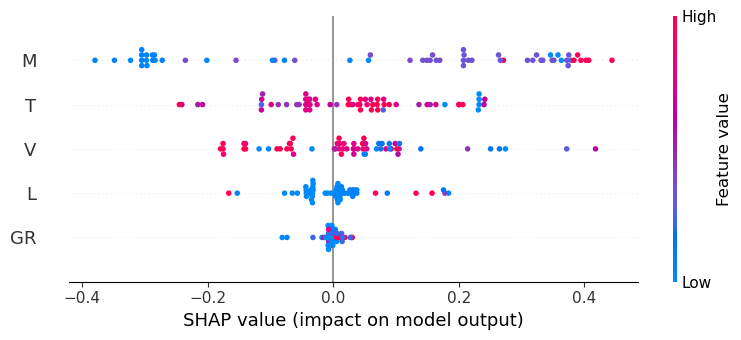

In [29]:
from sklearn.svm import SVC
# The Best SVM Classifier 
SVM_C_best = SVC(kernel='rbf', C=10, gamma=0.1, probability=False, random_state=0)
SVM_C_best.fit(X_train, y_train)
y_predict = SVM_C_best.predict(X_test)

cm = confusion_matrix(y_test, y_predict)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['electrophobic', 'electrophilic'], yticklabels=['electrophobic', 'electrophilic'])

cross_val_best = cross_val_score(SVM_C_best, X_train, y_train, cv=5)
acc = accuracy_score(y_test, y_predict)
pre = precision_score(y_test, y_predict)
rec = recall_score(y_test, y_predict)
f1 = f1_score(y_test, y_predict)

plt.title('SVC', pad=10, fontsize=15)
plt.xlabel('Predictions', size=20)
plt.ylabel('Actuals', size=20)
plt.tick_params(which='both', direction='in', labelsize=15)

print(cross_val_best.mean())
print(acc)
print(pre)
print(rec)
print(f1)

plt.tight_layout()
plt.savefig('SVC Confusion Matrix.jpg', format='jpeg', dpi=600)
plt.show()

# use SHAP to explain and visualize the feature importance
import shap
shap.initjs()
# Creating the KernelExplainer
SVC_explainer = shap.KernelExplainer(SVM_C_best.predict, X_train)
SVC_shap_values = SVC_explainer.shap_values(X_test)
# Generating the bar plot with mean SHAP values and feature names
# Calculate mean absolute SHAP values for each feature
mean_abs_shap_values = np.mean(np.abs(SVC_shap_values), axis=0)

# Create a DataFrame for plotting with SHAP values
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': mean_abs_shap_values})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
# Plotting the feature importances with values
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
# Adding the values on the bars
for index, value in enumerate(importance_df['Importance']):
    plt.text(value, index, f'{value:.3f}', va='center', ha='left', color='black', fontweight='bold')

plt.xlim(0,0.35)
plt.xlabel('Mean Absolute SHAP Value', size=20)
plt.ylabel('Features', size=20)
plt.tick_params(which='both', direction='in', labelsize=15)
plt.text(0.25, len(importance_df) - 1.5, 'SVC', fontsize=25)
plt.tight_layout()
plt.savefig('SVC SHAP.jpg', format='jpeg', dpi=600)
plt.show()
# Generating the summary plot showing the distribution of SHAP values for each feature
shap.summary_plot(SVC_shap_values, X_test, feature_names=X.columns)

In [8]:
# XGBoosting Classifier

from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV

params_grid = {
    'n_estimators': [5, 10, 15, 20],
    'eta': [0.05, 0.1, 0.15, 0.2],
    'max_depth': [3, 4, 5, 6],
    'colsample_bytree': [0.5, 1],
    'subsample': [0.5, 1],
    'eval_metric': ['logloss']
}

XGBC = XGBClassifier(random_state=0)
grid_search = GridSearchCV(estimator=XGBC, param_grid=params_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

print('Best parameters:',grid_search.best_params_)

Fitting 5 folds for each of 256 candidates, totalling 1280 fits
Best parameters: {'colsample_bytree': 1, 'eta': 0.2, 'eval_metric': 'logloss', 'max_depth': 5, 'n_estimators': 20, 'subsample': 1}


[0.848639455782313, 0.8731292517006803, 0.8894557823129251, 0.8853741496598639, 0.8607993197278911, 0.8893707482993196, 0.9179421768707483, 0.9138605442176871, 0.9097789115646258, 0.8975340136054422, 0.9221938775510203, 0.9181122448979593, 0.9138605442176871, 0.9056972789115646, 0.9343537414965987, 0.9303571428571429, 0.9098639455782314, 0.9179421768707483, 0.9467687074829932, 0.9302721088435375]
[0.8852459016393442, 0.8688524590163934, 0.8688524590163934, 0.8688524590163934, 0.8852459016393442, 0.8852459016393442, 0.8852459016393442, 0.8852459016393442, 0.8852459016393442, 0.8852459016393442, 0.8852459016393442, 0.8852459016393442, 0.8852459016393442, 0.9180327868852459, 0.8852459016393442, 0.8852459016393442, 0.9180327868852459, 0.9180327868852459, 0.9016393442622951, 0.8852459016393442]
[0.9523809523809523, 0.9512195121951219, 0.9512195121951219, 0.9512195121951219, 0.9523809523809523, 0.9523809523809523, 0.9523809523809523, 0.9523809523809523, 0.9523809523809523, 0.9523809523809523

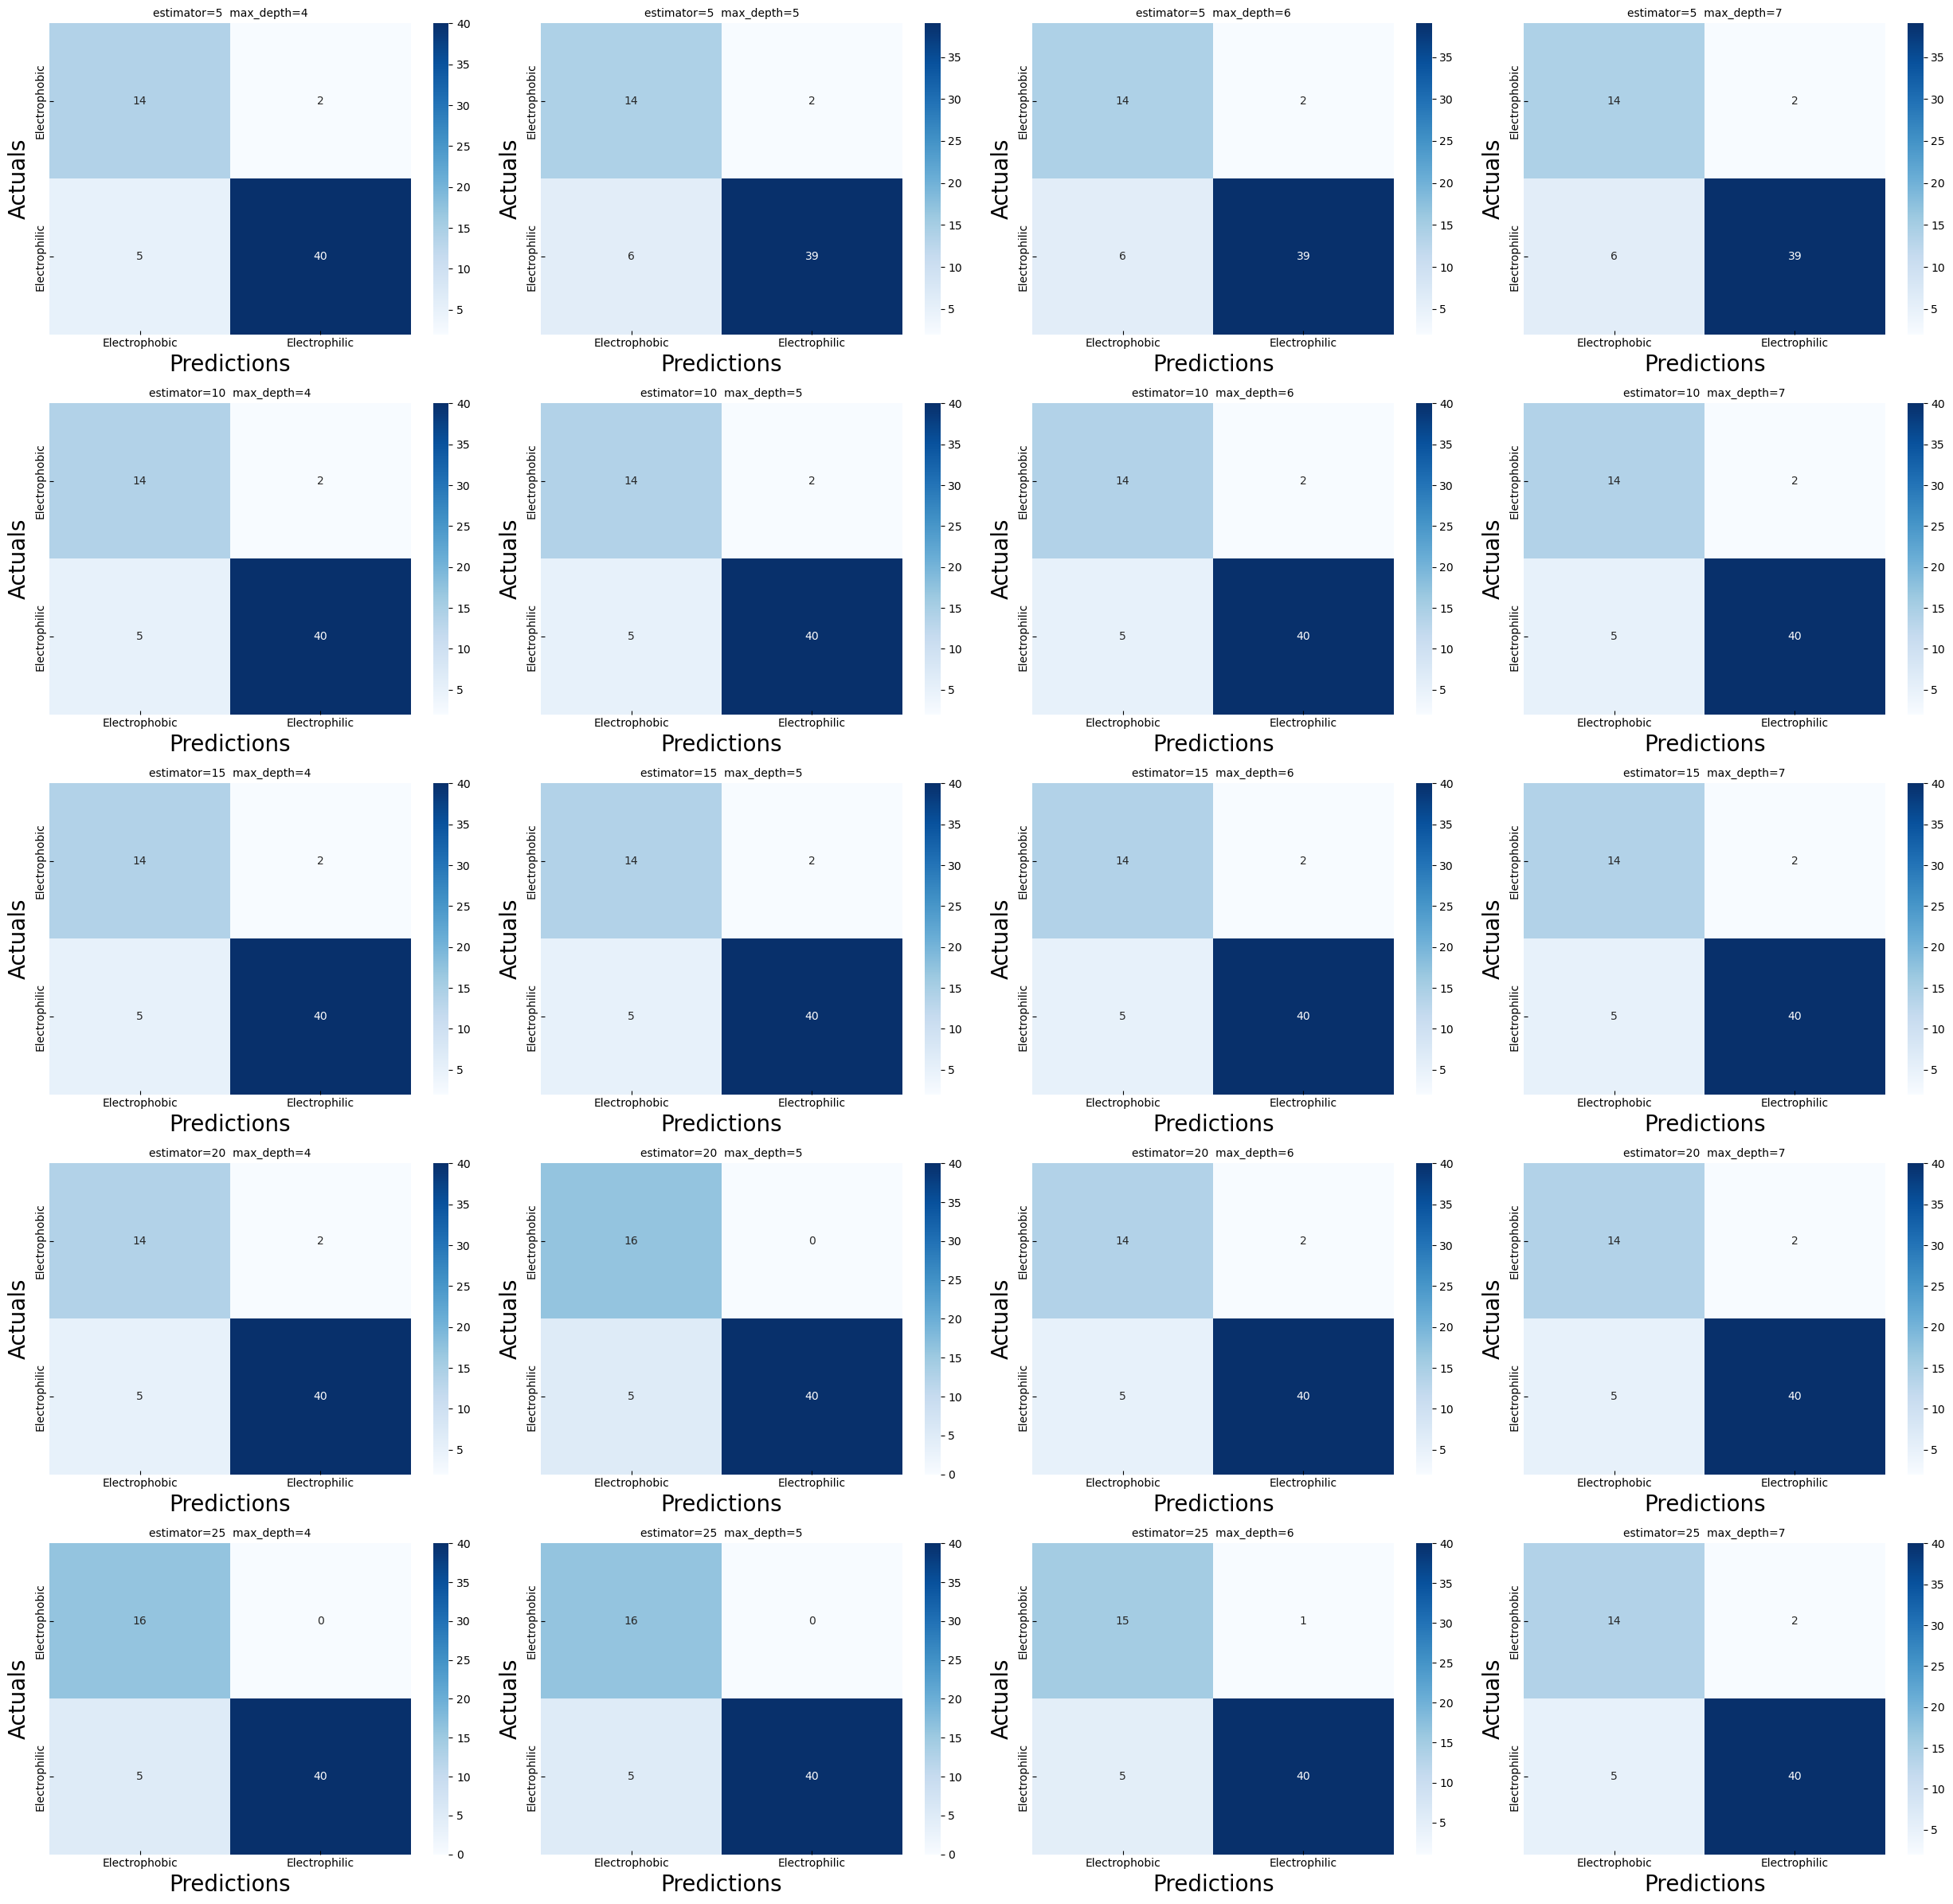

In [23]:
n = [5, 10, 15, 20, 25]
m = [4, 5, 6, 7]

fig, subaxes = plt.subplots(len(n), len(m), figsize=(len(n)*5, len(m)*6))

all_cross_val = []
all_acc = []
all_pre = []
all_rec = []
all_f1 = []

for i, this_n in enumerate(n):
    for j, this_m in enumerate(m):
        XGBC = XGBClassifier(n_estimators=this_n, eta=0.3, max_depth=this_m, colsample_bytree=1, subsample=1, random_state=0)
        XGBC.fit(X_train, y_train)
        y_predict = XGBC.predict(X_test)
        y_predict2 = XGBC.predict(X_train)

        cm = confusion_matrix(y_test, y_predict)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=subaxes[i,j],
                      xticklabels=['Electrophobic','Electrophilic'], yticklabels=['Electrophobic','Electrophilic'])

        subaxes[i,j].set_title(f'estimator={this_n}  max_depth={this_m}', size=10)
        subaxes[i,j].set_xlabel('Predictions', size=20)
        subaxes[i,j].set_ylabel('Actuals', size=20)
        subaxes[i,j].tick_params(direction='in', which='both')
        
        cross_val = cross_val_score(XGBC, X_train, y_train, cv=5)
        acc = accuracy_score(y_test, y_predict)
        pre = precision_score(y_test, y_predict)
        rec = recall_score(y_test, y_predict)
        f1 = f1_score(y_test, y_predict)
        
        all_cross_val.append(cross_val.mean())
        all_acc.append(acc)
        all_pre.append(pre)
        all_rec.append(rec)
        all_f1.append(f1)

print(all_cross_val)
print(all_acc)
print(all_pre)
print(all_rec)
print(all_f1)
plt.subplots_adjust(wspace=0.3, hspace=0.3)

plt.tight_layout()
plt.savefig('XGBC classification matrix.jpg', format='jpeg', dpi=600)
plt.show()

0.9179421768707483
0.8852459016393442
0.9523809523809523
0.8888888888888888
0.9195402298850575


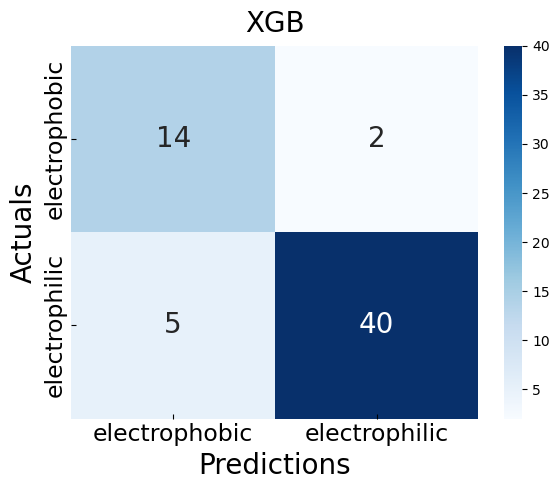

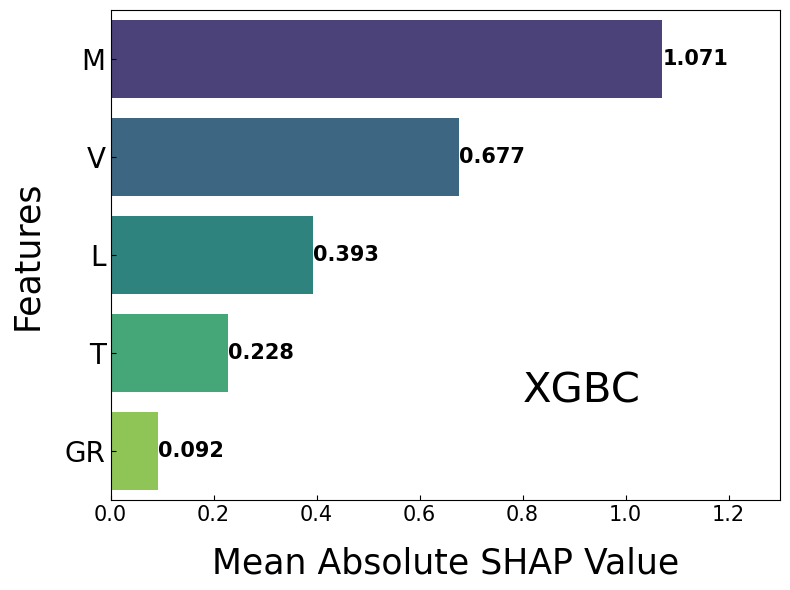

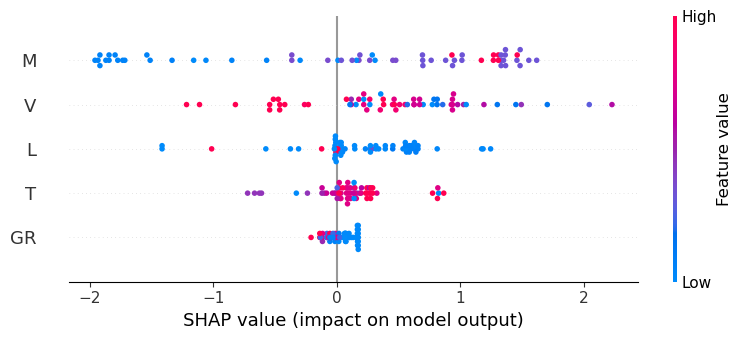

In [25]:
import shap

from xgboost.sklearn import XGBClassifier
# XGBoosting Classifier
XGBC_best = XGBClassifier(n_estimators=10, eta=0.3, max_depth=6, colsample_bytree=1, subsample=1, random_state=0)
XGBC_best.fit(X_train, y_train)
y_predict = XGBC_best.predict(X_test)
y_predict2 = XGBC_best.predict(X_train)

plt.figure(figsize=(6,5))
cm = confusion_matrix(y_test, y_predict)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                      xticklabels=['electrophobic','electrophilic'], yticklabels=['electrophobic','electrophilic'], annot_kws={'size': 20})

cross_val = cross_val_score(XGBC_best, X_train, y_train, cv=5)
acc = accuracy_score(y_test, y_predict)
pre = precision_score(y_test, y_predict)
rec = recall_score(y_test, y_predict)
f1 = f1_score(y_test, y_predict)

print(cross_val.mean())
print(acc)
print(pre)
print(rec)
print(f1)

plt.title('XGB', pad=10, fontsize=20)
plt.xlabel('Predictions', size=20)
plt.ylabel('Actuals', size=20)
plt.tick_params(direction='in', which='both', labelsize=17)

plt.tight_layout()
plt.savefig('XGBC Confusion Matrix.jpg', format='jpeg', dpi=600)
plt.show()

# SHAP Values Calculation and Visualization
shap.initjs()

# Create the explainer using TreeExplainer
XGBC_explainer = shap.TreeExplainer(XGBC_best)
XGBC_shap_values = XGBC_explainer.shap_values(X_test)

# Calculate mean absolute SHAP values for each feature
mean_abs_shap_values = np.mean(np.abs(XGBC_shap_values), axis=0)

# Create a DataFrame for plotting with SHAP values
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': mean_abs_shap_values})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plotting the feature importances with values
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
for index, value in enumerate(importance_df['Importance']):
    plt.text(value, index, f'{value:.3f}', va='center', ha='left', color='black', fontweight='bold', fontsize=15)

plt.xlim(0,1.3)
plt.xlabel('Mean Absolute SHAP Value', size=25, labelpad=15)
plt.ylabel('Features', size=25, labelpad=15)
plt.tick_params(axis='x', direction='in', labelsize=15)
plt.tick_params(axis='y', direction='in', labelsize=20)
plt.text(0.8, len(importance_df) - 1.5, 'XGBC', fontsize=30)
plt.tight_layout()
plt.savefig('XGBC SHAP.jpg', format='jpeg', dpi=600)
plt.show()

# Generating the summary plot showing the distribution of SHAP values for each feature
shap.summary_plot(XGBC_shap_values, X_test, feature_names=X.columns)

In [11]:
# KNN Classifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

params_grid = {
    'n_neighbors': [4, 5, 6, 7, 8, 9],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

KNNC = KNeighborsClassifier()
grid_search = GridSearchCV(estimator=KNNC, param_grid=params_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train, y_train)

print('Best parameters: ', grid_search.best_estimator_)

Best parameters:  KNeighborsClassifier(metric='manhattan', n_neighbors=6)


[0.8198129251700681, 0.819812925170068, 0.8403911564625849, 0.811734693877551, 0.7912414965986394, 0.7665816326530612]
[0.819672131147541, 0.8032786885245902, 0.7868852459016393, 0.8032786885245902, 0.819672131147541, 0.8360655737704918]
[1.0, 0.9024390243902439, 0.9444444444444444, 0.9230769230769231, 0.9473684210526315, 0.926829268292683]
[0.7555555555555555, 0.8222222222222222, 0.7555555555555555, 0.8, 0.8, 0.8444444444444444]
[0.8607594936708861, 0.8604651162790697, 0.8395061728395062, 0.8571428571428571, 0.8674698795180723, 0.8837209302325582]


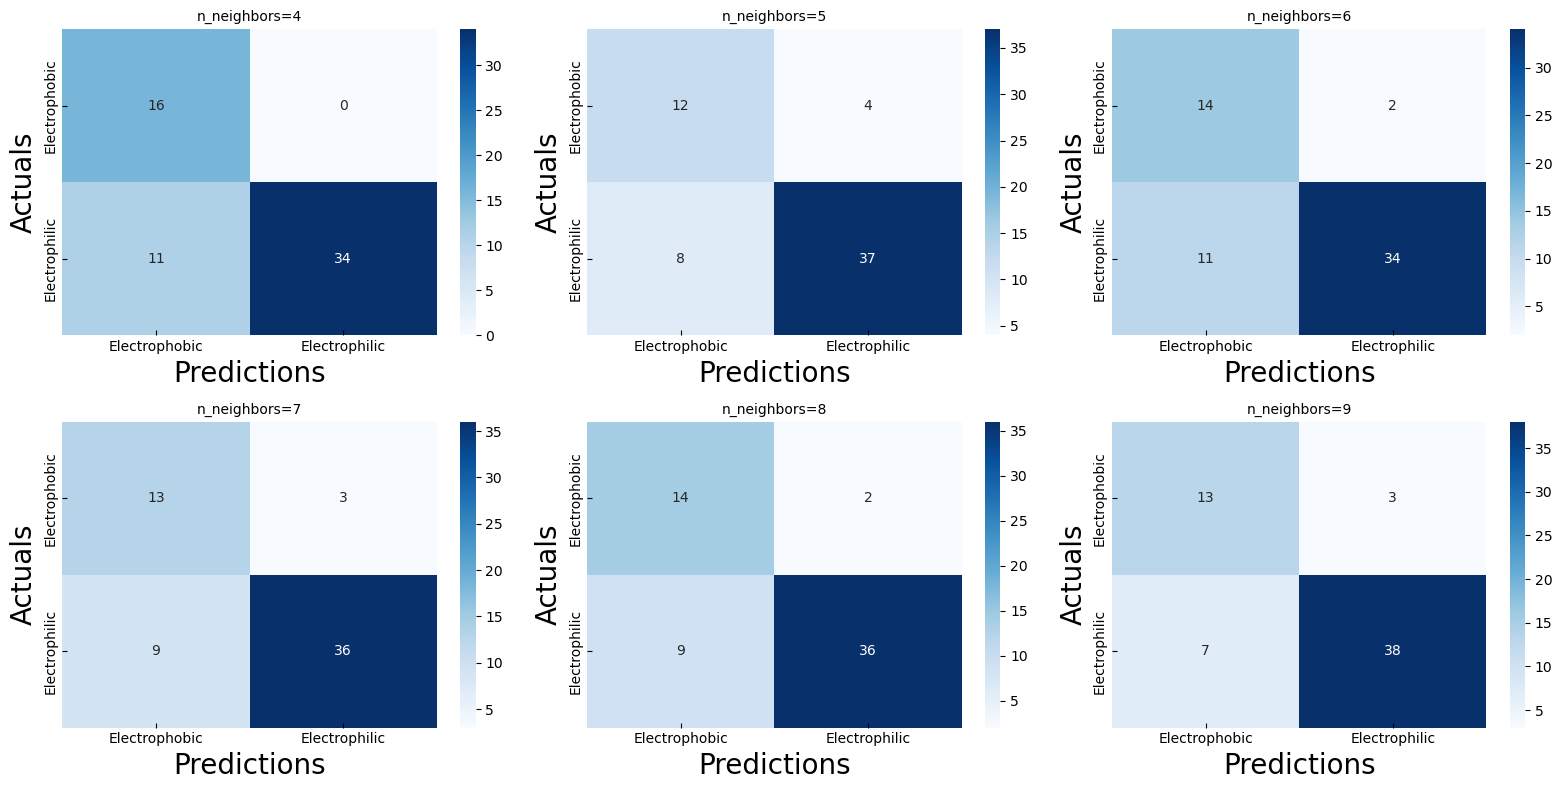

In [12]:
# KNN Classifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score

n = [4, 5, 6, 7, 8, 9]

fig, subaxes = plt.subplots(2, 3, figsize=(16, 8))

all_cross_val = []
all_acc = []
all_pre = []
all_rec = []
all_f1 = []

for i, this_n in enumerate(n):
    KNNC = KNeighborsClassifier(n_neighbors=this_n, metric='manhattan')
    KNNC.fit(X_train, y_train)
    y_predict = KNNC.predict(X_test)
    y_predict2 = KNNC.predict(X_train)

    cm = confusion_matrix(y_test, y_predict)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=subaxes[i // 3, i % 3],
               xticklabels=['Electrophobic','Electrophilic'], yticklabels=['Electrophobic','Electrophilic'])
    subaxes[i // 3, i % 3].set_title(f'n_neighbors={this_n}', fontsize=10)
    subaxes[i // 3, i % 3].set_xlabel('Predictions', size=20)
    subaxes[i // 3, i % 3].set_ylabel('Actuals', size=20)
    subaxes[i // 3, i % 3].tick_params(direction='in', which='both')

    cross_val = cross_val_score(KNNC, X_train, y_train, cv=5)
    acc = accuracy_score(y_test, y_predict)
    pre = precision_score(y_test, y_predict)
    rec = recall_score(y_test, y_predict)
    f1 = f1_score(y_test, y_predict)
    
    all_cross_val.append(cross_val.mean())
    all_acc.append(acc)
    all_pre.append(pre)
    all_rec.append(rec)
    all_f1.append(f1)

print(all_cross_val)
print(all_acc)
print(all_pre)
print(all_rec)
print(all_f1)
plt.subplots_adjust(wspace=0.3, hspace=0.3)

plt.tight_layout()
plt.savefig('KNNC classification matrix.jpg', format='jpeg', dpi=600)
plt.show()

0.819812925170068
0.8032786885245902
0.9024390243902439
0.8222222222222222
0.8604651162790697


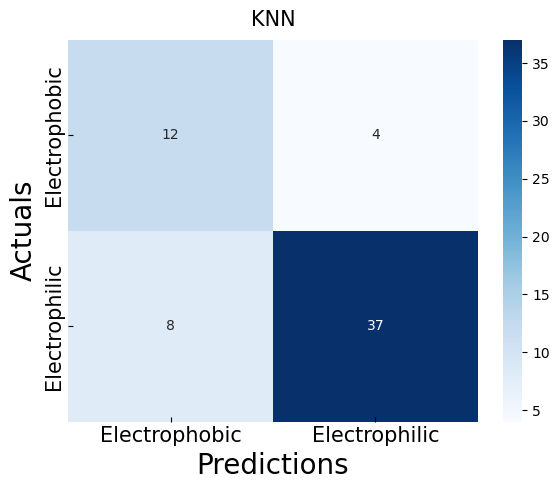

Using 244 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/61 [00:00<?, ?it/s]

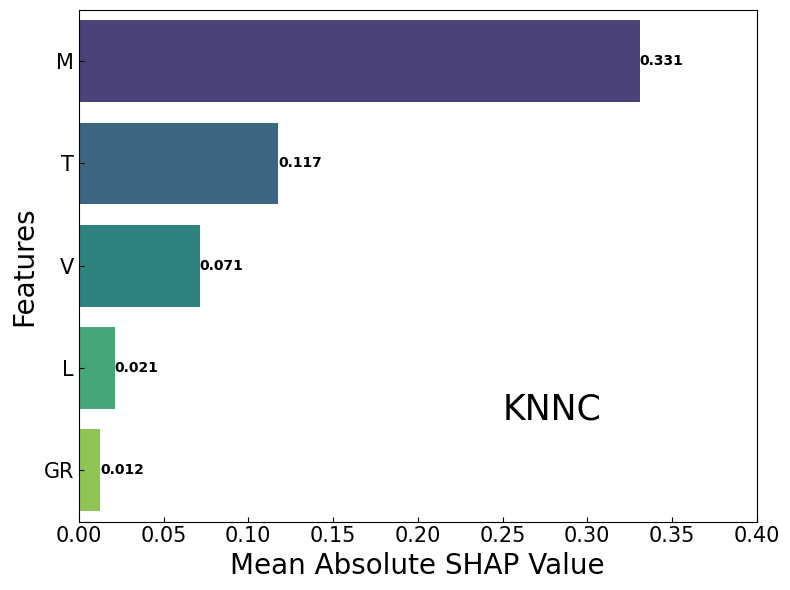

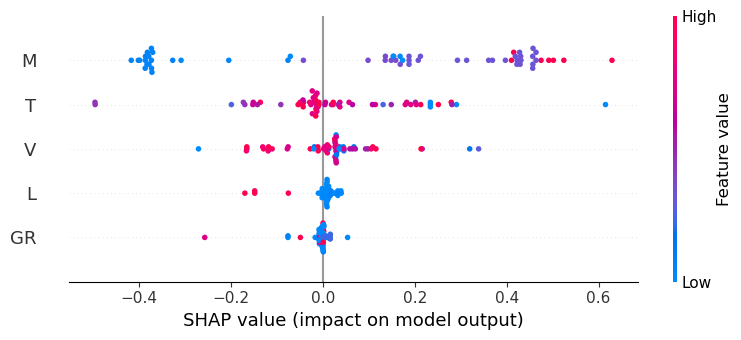

In [19]:
from sklearn.neighbors import KNeighborsClassifier
# The best KNN Classifier

KNNC_best = KNeighborsClassifier(n_neighbors=5, metric='manhattan')
KNNC_best.fit(X_train, y_train)
y_predict = KNNC_best.predict(X_test)
y_predict2 = KNNC_best.predict(X_train)

plt.figure(figsize=(6,5))
cm = confusion_matrix(y_test, y_predict)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                      xticklabels=['Electrophobic','Electrophilic'], yticklabels=['Electrophobic','Electrophilic'])

cross_val = cross_val_score(KNNC_best, X_train, y_train, cv=5)
acc = accuracy_score(y_test, y_predict)
pre = precision_score(y_test, y_predict)
rec = recall_score(y_test, y_predict)
f1 = f1_score(y_test, y_predict)

print(cross_val.mean())
print(acc)
print(pre)
print(rec)
print(f1)

plt.title('KNN', pad=10, fontsize=15)
plt.xlabel('Predictions', size=20)
plt.ylabel('Actuals', size=20)
plt.tick_params(direction='in', which='both', labelsize=15)

plt.tight_layout()
plt.savefig('KNNC Confusion Matrix.jpg', format='jpeg', dpi=600)
plt.show()

# use SHAP to explain and visualize the feature importance
import shap
shap.initjs()
# Creating the KernelExplainer
KNNC_explainer = shap.KernelExplainer(KNNC_best.predict, X_train)
KNNC_shap_values = KNNC_explainer.shap_values(X_test)

# Calculate mean absolute SHAP values for each feature
mean_abs_shap_values = np.mean(np.abs(KNNC_shap_values), axis=0)

# Create a DataFrame for plotting with SHAP values
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': mean_abs_shap_values})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plotting the feature importances with values
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
for index, value in enumerate(importance_df['Importance']):
    plt.text(value, index, f'{value:.3f}', va='center', ha='left', color='black', fontweight='bold')

plt.xlim(0, 0.4)
plt.xlabel('Mean Absolute SHAP Value', size=20)
plt.ylabel('Features', size=20)
plt.tick_params(which='both', direction='in', labelsize=15)
plt.text(0.25, len(importance_df) - 1.5, 'KNNC', fontsize=25)
plt.tight_layout()
plt.savefig('KNNC_SHAP.jpg', format='jpeg', dpi=600)
plt.show()

# Generating the summary plot showing the distribution of SHAP values for each feature
shap.summary_plot(KNNC_shap_values, X_test, feature_names=X.columns)

In [14]:
# Logistic Regression

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

# standardize the features, no need to do so for y since this is a binary classification (0 for electrophobic and 1 for electrophilic)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

LRC = LogisticRegression()
LRC.fit(X_train_scaled, y_train)
y_predict = LRC.predict(X_test_scaled)

param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(LRC, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

print("Best parameters:", grid_search.best_params_)

Best parameters: {'C': 1}


[0.536904761904762, 0.7498299319727892, 0.7499149659863945, 0.7662414965986394, 0.7621598639455782, 0.7621598639455782]
[0.7377049180327869, 0.7704918032786885, 0.7868852459016393, 0.7868852459016393, 0.7704918032786885, 0.7704918032786885]
[0.7377049180327869, 0.8780487804878049, 0.9, 0.9, 0.8974358974358975, 0.8974358974358975]
[1.0, 0.8, 0.8, 0.8, 0.7777777777777778, 0.7777777777777778]
[0.8490566037735848, 0.8372093023255814, 0.8470588235294118, 0.8470588235294118, 0.8333333333333333, 0.8333333333333333]


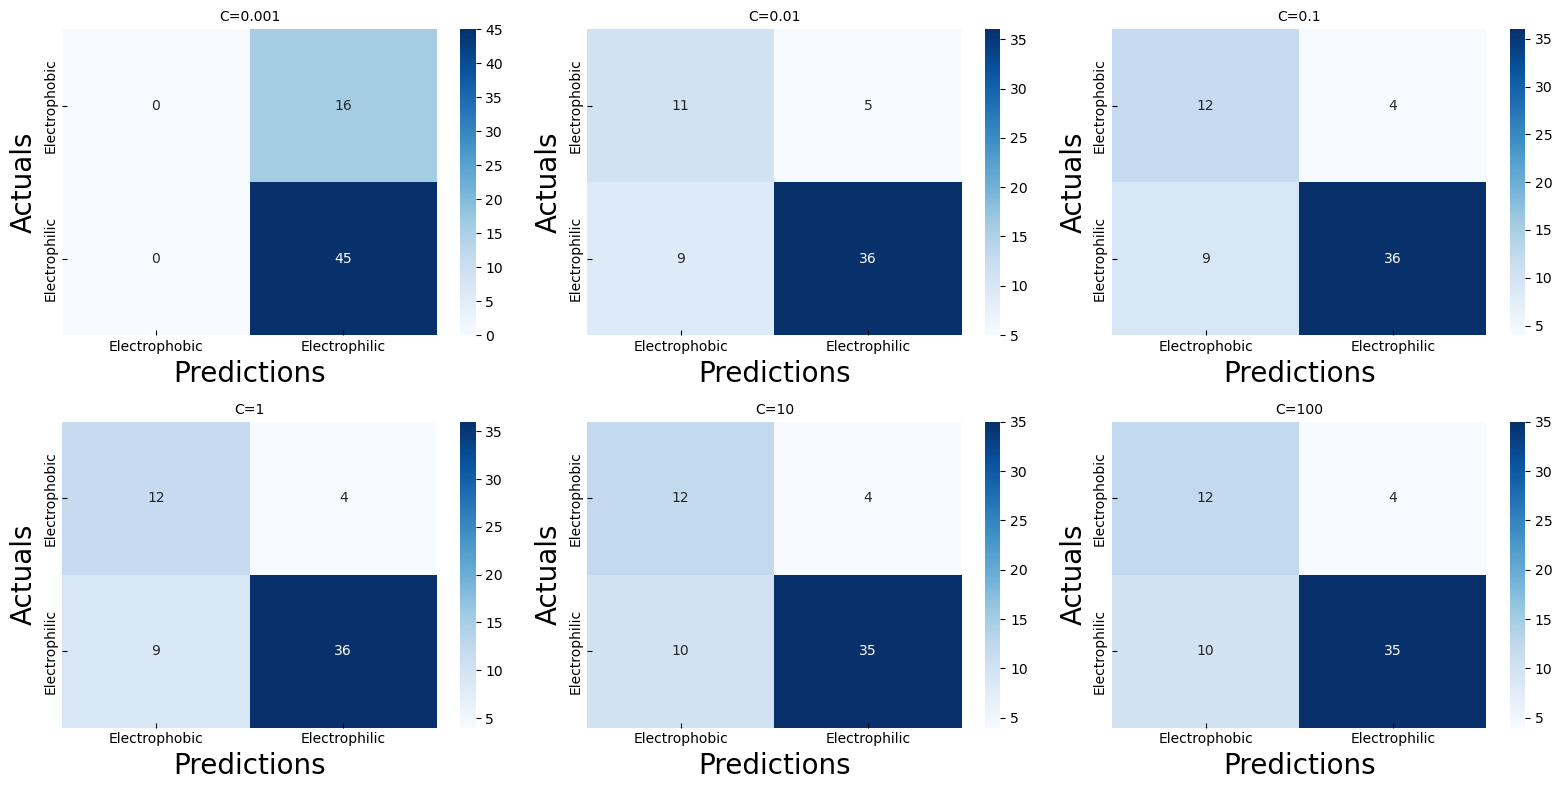

In [15]:
# Logistic Regression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score

n = [0.001, 0.01, 0.1, 1, 10, 100]

fig, subaxes = plt.subplots(2, 3, figsize=(16, 8))

all_cross_val = []
all_acc = []
all_pre = []
all_rec = []
all_f1 = []

for i, this_n in enumerate(n):
    LRC = LogisticRegression(C=this_n)
    LRC.fit(X_train_scaled, y_train)
    y_predict = LRC.predict(X_test_scaled)
    y_predict2 = LRC.predict(X_train_scaled)

    cm = confusion_matrix(y_test, y_predict)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=subaxes[i // 3, i % 3],
               xticklabels=['Electrophobic','Electrophilic'], yticklabels=['Electrophobic','Electrophilic'])
    subaxes[i // 3, i % 3].set_title(f'C={this_n}', fontsize=10)
    subaxes[i // 3, i % 3].set_xlabel('Predictions', size=20)
    subaxes[i // 3, i % 3].set_ylabel('Actuals', size=20)
    subaxes[i // 3, i % 3].tick_params(direction='in', which='both')

    cross_val = cross_val_score(LRC, X_train_scaled, y_train, cv=5)
    acc = accuracy_score(y_test, y_predict)
    pre = precision_score(y_test, y_predict)
    rec = recall_score(y_test, y_predict)
    f1 = f1_score(y_test, y_predict)
    
    all_cross_val.append(cross_val.mean())
    all_acc.append(acc)
    all_pre.append(pre)
    all_rec.append(rec)
    all_f1.append(f1)

print(all_cross_val)
print(all_acc)
print(all_pre)
print(all_rec)
print(all_f1)
plt.subplots_adjust(wspace=0.3, hspace=0.3)

plt.tight_layout()
plt.savefig('LRC classification matrix.jpg', format='jpeg', dpi=600)
plt.show()

0.7662414965986394
0.7868852459016393
0.9
0.8
0.8470588235294118


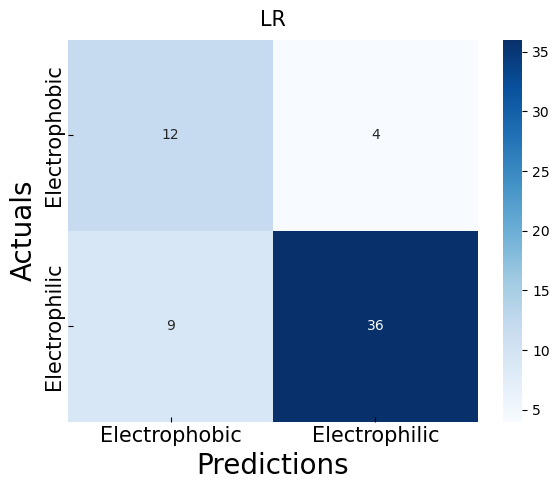

Using 244 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/61 [00:00<?, ?it/s]

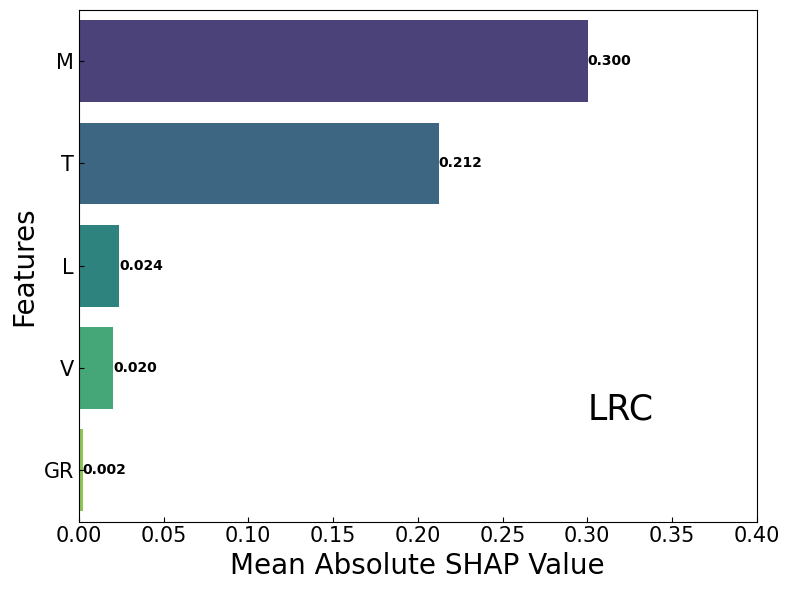

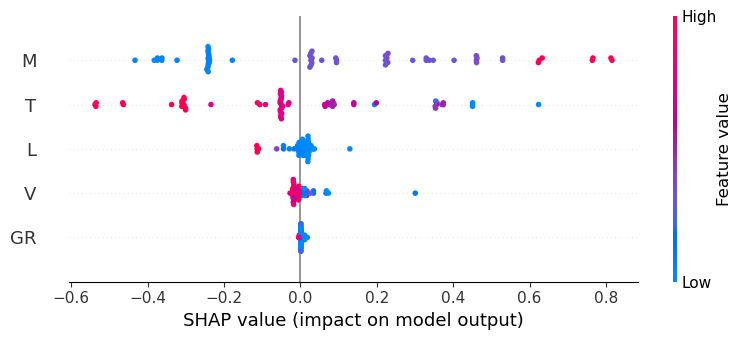

In [20]:
# Logistic Regression

LRC_best = LogisticRegression(C=1)
LRC_best.fit(X_train_scaled, y_train)
y_predict = LRC_best.predict(X_test_scaled)
y_predict2 = LRC_best.predict(X_train_scaled)

plt.figure(figsize=(6,5))
cm = confusion_matrix(y_test, y_predict)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Electrophobic','Electrophilic'], yticklabels=['Electrophobic','Electrophilic'])

cross_val = cross_val_score(LRC_best, X_train_scaled, y_train, cv=5)
acc = accuracy_score(y_test, y_predict)
pre = precision_score(y_test, y_predict)
rec = recall_score(y_test, y_predict)
f1 = f1_score(y_test, y_predict)

print(cross_val.mean())
print(acc)
print(pre)
print(rec)
print(f1)

plt.title('LR', pad=10, fontsize=15)
plt.xlabel('Predictions', size=20)
plt.ylabel('Actuals', size=20)
plt.tick_params(direction='in', which='both', labelsize=15)

plt.tight_layout()
plt.savefig('LRC Confusion Matrix.jpg', format='jpeg', dpi=600)
plt.show()

# use SHAP to explain and visualize the feature importance
import shap
shap.initjs()
# Creating the KernelExplainer
LRC_explainer = shap.KernelExplainer(LRC_best.predict, X_train)
LRC_shap_values = LRC_explainer.shap_values(X_test)

# Calculate mean absolute SHAP values for each feature
mean_abs_shap_values = np.mean(np.abs(LRC_shap_values), axis=0)

# Create a DataFrame for plotting with SHAP values
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': mean_abs_shap_values})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plotting the feature importances with values
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
for index, value in enumerate(importance_df['Importance']):
    plt.text(value, index, f'{value:.3f}', va='center', ha='left', color='black', fontweight='bold')

plt.xlim(0, 0.4)
plt.xlabel('Mean Absolute SHAP Value', size=20)
plt.ylabel('Features', size=20)
plt.tick_params(which='both', direction='in', labelsize=15)
plt.text(0.3, len(importance_df) - 1.5, 'LRC', fontsize=25)
plt.tight_layout()
plt.savefig('LRC_SHAP.jpg', format='jpeg', dpi=600)
plt.show()

# Generating the summary plot showing the distribution of SHAP values for each feature
shap.summary_plot(LRC_shap_values, X_test, feature_names=X.columns)

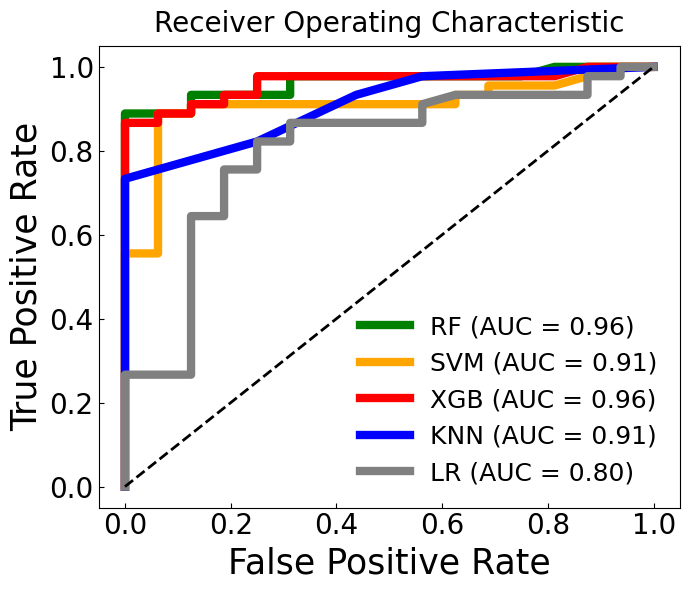

In [34]:
# Evaluation by ROC-AUC curve
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost.sklearn import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# ROC-AUC for RFC
RFC = RandomForestClassifier(n_estimators=15, max_depth=6, min_samples_split=2, random_state=0)
RFC.fit(X_train, y_train)
y_scores_RFC = RFC.predict_proba(X_test)[:, 1]
# calculate FPR and TPR in ROC curve
fpr_RFC, tpr_RFC, threshold_RFC = roc_curve(y_test, y_scores_RFC)
# calculate AUC
roc_auc_RFC = auc(fpr_RFC, tpr_RFC)

# ROC-AUC for SVC
svc = SVC(kernel='rbf', C=10, gamma=0.1, probability=True, random_state=0)
svc.fit(X_train, y_train)
y_scores_svc = svc.predict_proba(X_test)[:, 1]
fpr_svc, tpr_svc, threshold_svc = roc_curve(y_test, y_scores_svc)
roc_auc_svc = auc(fpr_svc, tpr_svc)

# ROC-AUC for XGBC
XGBC = XGBClassifier(n_estimators=10, eta=0.3, max_depth=6, colsample_bytree=1, subsample=1, random_state=0)
XGBC.fit(X_train, y_train)
y_scores_XGBC = XGBC.predict_proba(X_test)[:, 1]
fpr_XGBC, tpr_XGBC, threshold_XGBC = roc_curve(y_test, y_scores_XGBC)
roc_auc_XGBC = auc(fpr_XGBC, tpr_XGBC)

# ROC-AUC for KNNC
KNNC = KNeighborsClassifier(n_neighbors=5, metric='manhattan')
KNNC.fit(X_train, y_train)
y_scores_KNNC = KNNC.predict_proba(X_test)[:, 1]
fpr_KNNC, tpr_KNNC, threshold_KNNC = roc_curve(y_test, y_scores_KNNC)
roc_auc_KNNC = auc(fpr_KNNC, tpr_KNNC)

# ROC-AUC for LRC
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
LRC = LogisticRegression(C=1)
LRC.fit(X_train_scaled, y_train)
y_scores_LRC = LRC.predict_proba(X_test_scaled)[:, 1]
fpr_LRC, tpr_LRC, threshold_LRC = roc_curve(y_test, y_scores_LRC)
roc_auc_LRC = auc(fpr_LRC, tpr_LRC)

# plot ROC-AUC for RFC, SVC, XGBC, KNNC, LGC
plt.figure(figsize=(7,6))

plt.plot(fpr_RFC, tpr_RFC, color='green', lw=6, label='RF (AUC = %0.2f)' % roc_auc_RFC)
plt.plot(fpr_svc, tpr_svc, color='orange', lw=6, label='SVM (AUC = %0.2f)' % roc_auc_svc)
plt.plot(fpr_XGBC, tpr_XGBC, color='red', lw=6, label='XGB (AUC = %0.2f)' % roc_auc_XGBC)
plt.plot(fpr_KNNC, tpr_KNNC, color='blue', lw=6, label='KNN (AUC = %0.2f)' % roc_auc_KNNC)
plt.plot(fpr_LRC, tpr_LRC, color='grey', lw=6, label='LR (AUC = %0.2f)' % roc_auc_LRC)

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', size=25)
plt.ylabel('True Positive Rate', size=25)
plt.tick_params(axis='x', labelsize=20, direction='in')
plt.tick_params(axis='y', labelsize=20, direction='in')
plt.title('Receiver Operating Characteristic', pad=10, fontsize=20)
plt.legend(fontsize=18, loc=4, frameon=False)

plt.tight_layout()
plt.savefig('ROC-AUC.jpg', format='jpeg', dpi=600)
plt.show()

In [18]:
# Model validation by new data collected from experiments using newly synthesized materials, namely 10 wt.%Fe/ZnO
